In [1]:
# Make sure impact2_engine is on the search path in one way or the other
import sys
sys.path.append('../../')
import yaml
from impact2_engine.Power import Power

with open('../../impact2_engine/config/power_config.yml', 'r', encoding = 'utf-8') as stream:
    config = yaml.safe_load(stream)

config['data_path'] = '../../impact2_engine/data/' + config['data_path']
pwr = Power(**config)

# Power simulation

The module consists of two parts / functions:

1. `posterior` assession of the AE probabilities, using both the observed data and prior / user expectations;

2. `simulate` from the hypothesized parameter values for various sample sizes, adding the previous data.

The full procedure can be schematically viewed in the figure. The detailed description follows below.

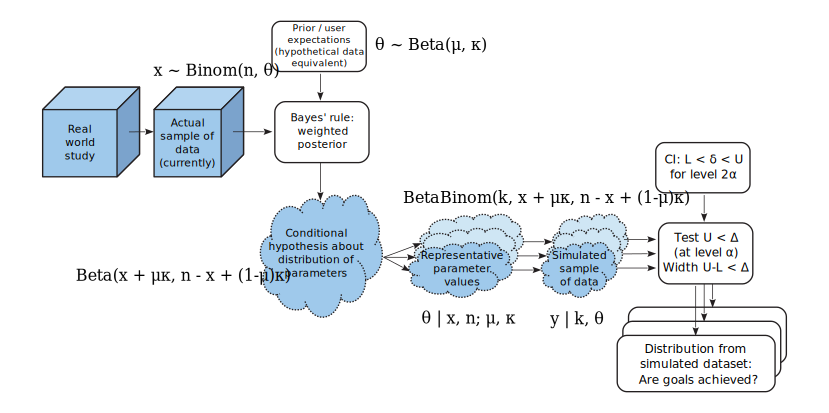

In [2]:
from IPython.core.display import SVG
SVG(filename = 'Kruschke_fig13-2.svg')

## Conditioning on data together with user expectations (prior) 

Our sampling strategy **takes into account the uncertainty** about *actual* AE probabilities $\theta_i$, expressed via posterior distribution. We use **independent Binomial** data model, with **conjugate Beta** distribution of *unknown* parameters in 2 groups $i = A, B$:

$$
\begin{align*}
x_i \ \sim & \ \mathrm{Binom}(n_i, \, \theta_i), \\
\theta_i \ \sim & \ \mathrm{Beta}(\alpha_i, \, \beta_i), \\
\theta_i \, \big| \, x_i,\, n_i;\, \alpha_i,\, \beta_i \ \sim & \ \mathrm{Beta}(x_i + \alpha_i, \, n_i - x_i + \beta_i)
\end{align*}
$$

It is convenient to express the equivalent 'prior number of successes/failures' as:

$$\alpha = \mu \kappa, \quad \beta = (1-\mu) \kappa$$
where $\mu = \frac{\alpha}{\alpha + \beta}$ is the mean, and the *concentration* parameter $\kappa = \alpha + \beta$ expresses the confidence in terms of 'prior sample size' equivalent. The expectation for AE proportions are:

$$
\mathrm{E}[\theta_i \, | \, x_i, n_i] \ = \ \frac{\alpha_i + x_i}{\alpha_i + \beta_i + n_i} \\
= \ \underbrace{\frac{\alpha_i + \beta_i}{\alpha_i + \beta_i + n_i}}_{\displaystyle \text{prior weight}} \times \underbrace{\frac{\alpha_i}{\alpha_i + \beta_i}}_{\displaystyle \text{user expectation} \ \mathrm{E}[\theta_i]} + \underbrace{\frac{n_i}{\alpha_i + \beta_i + n_i}}_{\displaystyle \text{data weight}} \times \underbrace{\frac{x_i}{n_i}}_{\displaystyle \text{sample average}}
$$

In [3]:
# All arguments are optional
post = pwr.posterior(
    prior_p = (.5, .5),    # expected probability (Jeffreys, ignorance)
    prior_n = (1, 1),      # concentration, sample size equivalent (Jeffreys, ignorance)
    severity = 'sig_hyp',  # severity type (1.2+ by default)
    time_point = None      # use data <= date (all by default)
)
post

,group,n_aes,n_col,observed_p,expected_p,prior_n,post_n,weighted_p,success,failure,margin
0,A,6,11775,0.000510,0.5,1,11776,0.000552,6.5,11769.5,0.0015
1,B,4,11362,0.000352,0.5,1,11363,0.000396,4.5,11358.5,0.0015


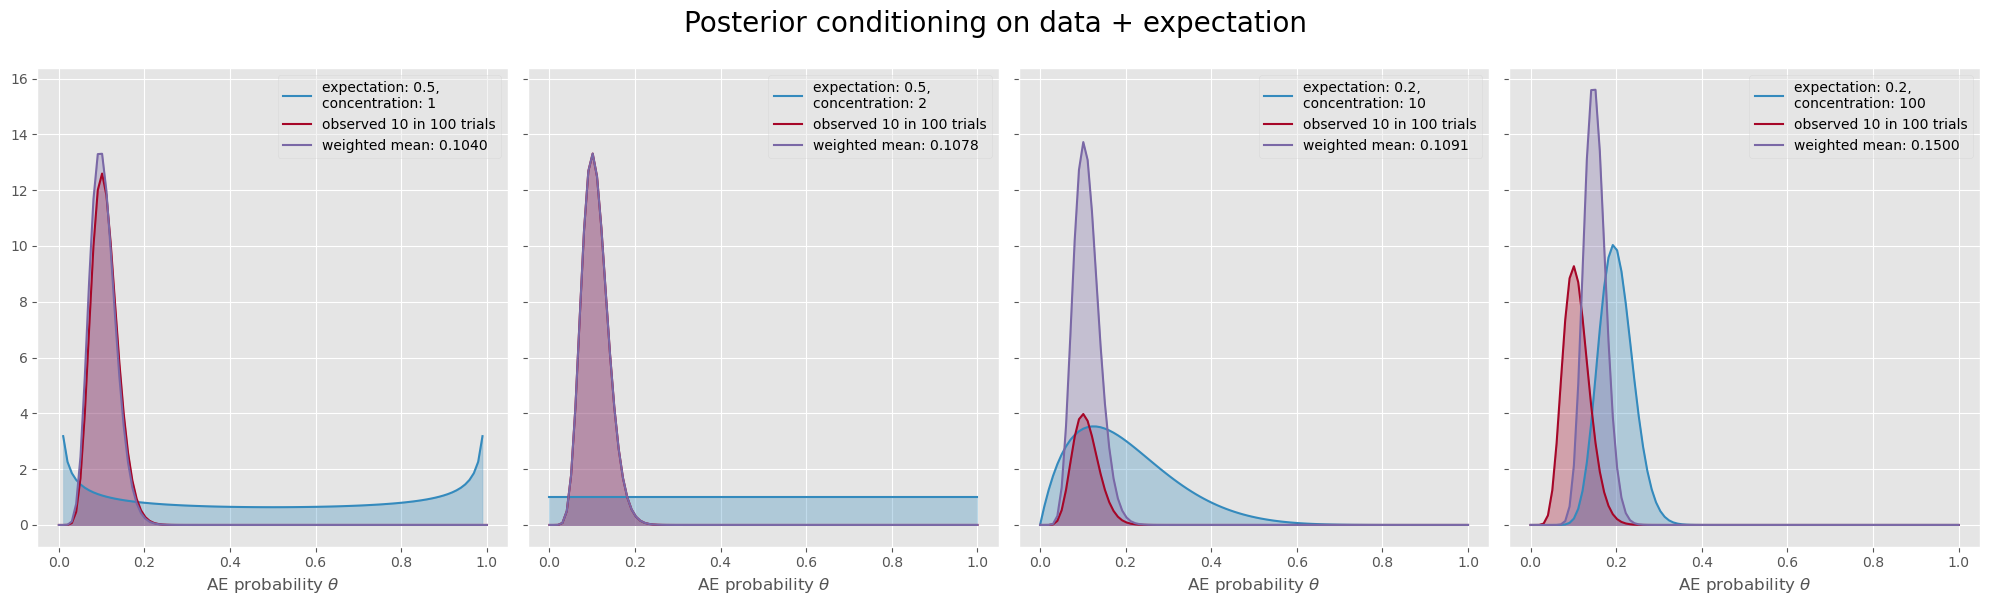

In [4]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.style.use("ggplot")

import scipy.stats as stats

x = np.linspace(0, 1, 100)

prior_p = [.5, .5, .2, .2]
prior_n = [1, 2, 10, 100]
n_aes = [10, 10, 10, 10]
n_col = [100, 100, 100, 100]
clr = ["#348ABD", "#A60628", "#7A68A6"]

fig, axes = plt.subplots(
    nrows = 1, ncols = 4, 
    figsize = (20, 6),
    sharey = True,
    tight_layout = True
)
fig.suptitle('Posterior conditioning on data + expectation', y = 1, fontsize = 20)

for k, par in enumerate(zip(prior_p, prior_n, n_aes, n_col)):

    ax = axes[k]
  
    y = stats.beta.pdf(x, a = par[0] * par[1], b = (1 - par[0]) * par[1])  
    
    ax.plot(x, y, label = 'expectation: %s,\nconcentration: %d' % par[0:2], color = clr[0])
    ax.fill_between(x, 0, y, color = clr[0], alpha = 0.3)

    like = stats.binom.pmf(k = par[2], n = par[3], p = x)
    evid = stats.betabinom.pmf(
        k = par[2], n = par[3],
        a = par[0] * par[1], b = (1 - par[0]) * par[1]
    )
    y = like / evid
    
    ax.plot(x, y, label = 'observed %d in %d trials' % par[2:], color = clr[1])
    ax.fill_between(x, 0, y, color = clr[1], alpha = 0.3)

    y = stats.beta.pdf(
        x, 
        a = par[0] * par[1] + par[2], 
        b = par[3] - par[2] + (1 - par[0]) * par[1]
    )

    weighted_p = (par[0] * par[1] + par[2]) / (par[1] + par[3])
    
    ax.plot(x, y, label = 'weighted mean: %.4f' % weighted_p, color = clr[2])
    ax.fill_between(x, 0, y, color = clr[2], alpha = 0.3)
    
    ax.set_xlabel('AE probability $\\theta$')
    ax.autoscale(enable = True, axis = 'y')
    
    leg = ax.legend()
    leg.get_frame().set_alpha(0.4)


## Sampling strategy

1. Set the user defined expectations about AE probabilities in terms of $(\mu_i, \kappa_i)$, or use the convenient *Jeffreys default prior*: $\mu = \frac12, \kappa = 1$ for both groups.

2. Use observed data $(x_i, n_i)$ together with the user/default prior to derive the posterior expectations about $\theta_i$.

3. Set the desired number $S$ of simulated draws.

4. Choose the number of trials $2k$ (including conducted $n_A + n_B$ observations), that is the sample size of interest $(k > \max(n_i))$.

5. Sample $S$ *unobserved* parameter values $\theta_i$ from the corresponding Beta distributions.

6. Simulate the *observed* numbers $y_i$ of AE in $k - n_i$ trials, by drawing $S$ samples from the Binomial distributions with parameters $\theta_i$.

7. Perform the tests on simulated $(y)$ + observed $(x)$ data, recorging the results as $z \in \{0,1\}$. Estimate the power as proportion of successes, for various hypotheses about $\theta_i$:

    $$\frac{\sum z}{S} \ \approx \ \left(\prod_{i = A,B} \int_0^1 d\theta_i \ p(\theta_i\, |\, x_i,\, n_i;\, \mu_i,\, \kappa_i) \right) p(z = 1\, |\, k,\, \theta_A, \theta_B)$$

NOTE: The non-inferiority test assesses only wheter the combination $\delta = \theta_B-\theta_A > \Delta$ (some fixed margin), irrespectively of the *nuisance parameter* $\eta = \theta_A + \theta_B$. Our simulating from individual $\theta_i$ distributions, thus, effectively averages (marginalizes) out the $\eta$-part of the joint probability.

STREAMLINE instead the two steps 5-6 into the single-stage sampling from the **posterior predictive distribution**, by analytically integrating over $\theta$:

$$y_i \, \big| \, x_i,\, n_i;\, \mu_i,\, \kappa_i \ \sim \ \mathrm{BetaBinom}(k - n_i, x_i + \mu_i\kappa_i, \, n_i - x_i + (1-\mu_i)\kappa_i)$$

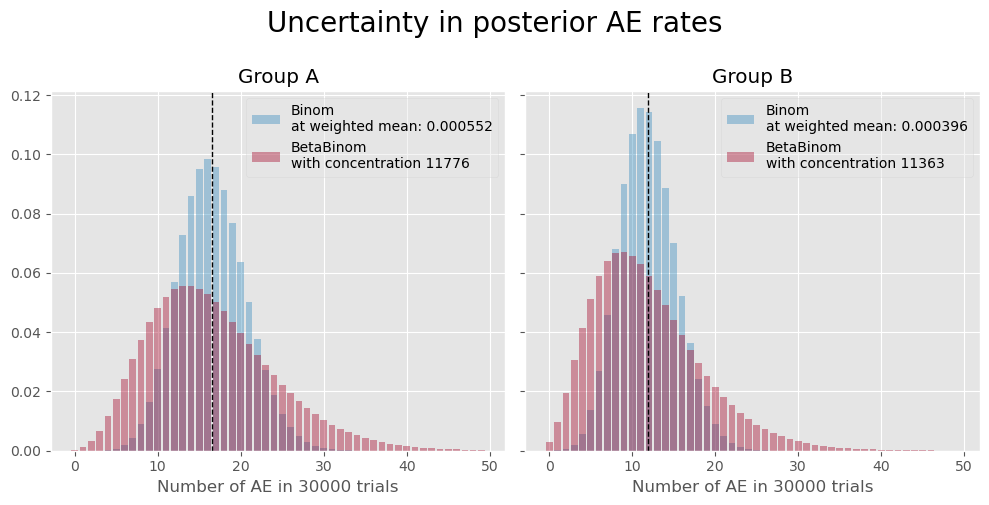

In [5]:
n_trials = 30000

fig, axes = plt.subplots(
    nrows = 1, ncols = 2, 
    figsize = (10, 5),
    sharey = True,
    tight_layout = True
)

fig.suptitle('Uncertainty in posterior AE rates', y = 1, fontsize = 20)

x = np.arange(0, 50, 1)
clr = ["#348ABD", "#A60628"]

for k, group in post.iterrows():

    ax = axes[k]

    ax.axvline(group['weighted_p'] * n_trials, color = 'k', lw = 1, linestyle="--")

    y = stats.binom.pmf(k = x, n = n_trials, p = group['weighted_p'])
    ax.bar(x, y, label = 'Binom\nat weighted mean: %f' % group['weighted_p'], color = clr[0], alpha = .4)
    # ax.fill_between(x, 0, y, color = clr[0], alpha = 0.4)

    y = stats.betabinom.pmf(k = x, n = n_trials, a = group['success'], b = group['failure'])
    ax.bar(x, y, label = 'BetaBinom\nwith concentration %d' % group['post_n'], color = clr[1], alpha = .4)
    
    ax.autoscale(enable = True, axis = 'both')
    
    leg = ax.legend()
    leg.get_frame().set_alpha(0.4)

    ax.set_xlabel('Number of AE in %d trials' % n_trials)
    ax.set_title('Group %s' % group['group'])

In [6]:
# Uses posterior, optionally takes all its arguments (same defaults)
smry = pwr.simulate(
    samples = 200000,         # number of simulations for each sample size
    step = 1000,             # increase sample size in steps, within [current, 100000 / 2]
    alpha = .05,             # 1st type error rate for NI test, using 2-sided CI (level = 1 - 2 x alpha)
    method = 'wald_cc',      # CI method for NI test
    time_point = '2020-02-01'
)
smry

,width_mean,width_power,u_mean,u_std,u_median,u_025,u_975,test_power,test_pwr_LL,test_pwr_UL
2000,0.3488,0.0000,0.1088,0.0903,0.0947,-0.0600,0.3208,75.4010,75.18,75.62
3000,0.3141,0.0000,0.0831,0.1169,0.0732,-0.1407,0.3474,76.4425,76.22,76.66
4000,0.2865,0.0000,0.0642,0.1324,0.0569,-0.1928,0.3570,78.1440,77.93,78.36
5000,0.2642,0.6825,0.0496,0.1429,0.0449,-0.2295,0.3615,79.6850,79.47,79.89
6000,0.2460,1.8615,0.0384,0.1496,0.0335,-0.2569,0.3621,80.6160,80.41,80.82
7000,0.2313,4.3785,0.0291,0.1562,0.0247,-0.2824,0.3627,81.8015,81.60,82.00
8000,0.2184,7.1210,0.0217,0.1594,0.0175,-0.2969,0.3585,82.2035,82.00,82.40
9000,0.2077,9.5870,0.0150,0.1637,0.0115,-0.3137,0.3615,82.5955,82.40,82.79
10000,0.1984,13.6305,0.0100,0.1661,0.0075,-0.3240,0.3608,83.0850,82.89,83.28
11000,0.1899,17.4250,0.0042,0.1681,0.0029,-0.3391,0.3549,83.7595,83.57,83.95


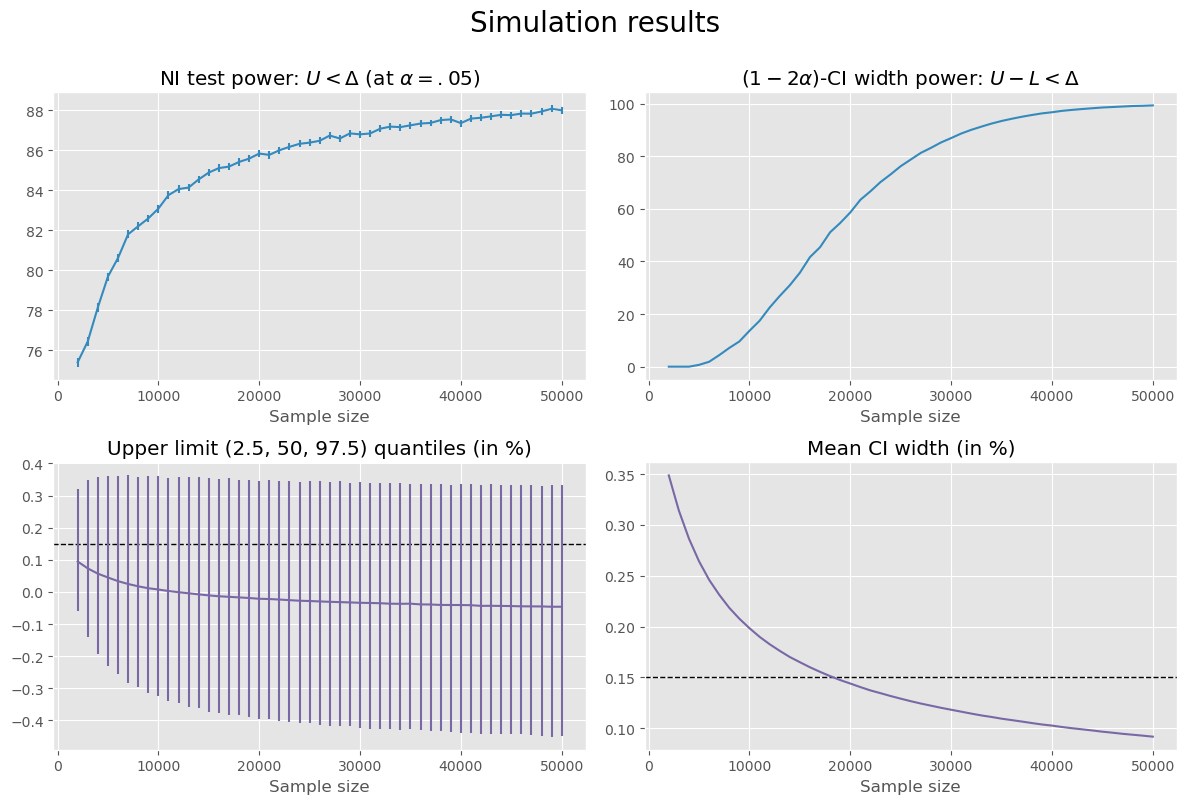

In [7]:
fig, ax = plt.subplots(
    nrows = 2, ncols = 2, 
    figsize = (12, 8),
    tight_layout = True
)

fig.suptitle('Simulation results', y = 1, fontsize = 20)

x = smry.index
clr = ["#348ABD", "#7A68A6"]

lower_err = (smry['test_pwr_LL'] - smry['test_power']).abs() 
upper_err = (smry['test_pwr_UL'] - smry['test_power']).abs()
yerr = [lower_err, upper_err]

ax[0,0].errorbar(x, smry['test_power'], yerr = yerr, color = clr[0])  
ax[0,0].autoscale(enable = True, axis = 'y')
ax[0,0].set_xlabel('Sample size')
ax[0,0].set_title('NI test power: $U < \\Delta$ (at $\\alpha = .05$)')

ax[0,1].plot(x, smry['width_power'], color = clr[0])
ax[0,1].autoscale(enable = True, axis = 'y')
ax[0,1].set_xlabel('Sample size')
ax[0,1].set_title('$(1 - 2\\alpha)$-CI width power: $U-L < \\Delta$')

lower_err = (smry['u_025'] - smry['u_median']).abs() 
upper_err = (smry['u_975'] - smry['u_median']).abs()
yerr = [lower_err, upper_err]

ax[1,0].axhline(post['margin'][0] * 100, color = 'k', lw = 1, linestyle="--")
ax[1,0].errorbar(x, smry['u_median'], yerr = yerr, color = clr[1])
ax[1,0].autoscale(enable = True, axis = 'y')
ax[1,0].set_xlabel('Sample size')
ax[1,0].set_title('Upper limit (2.5, 50, 97.5) quantiles (in %)')

ax[1,1].axhline(post['margin'][0] * 100, color = 'k', lw = 1, linestyle="--")
ax[1,1].plot(x, smry['width_mean'], color = clr[1])
ax[1,1].autoscale(enable = True, axis = 'y')
ax[1,1].set_xlabel('Sample size')
ax[1,1].set_title('Mean CI width (in %)')

plt.show()